In [1]:
!pip install tensorflow==2.0.0-beta0
!pip install -q tensorflow-datasets

     |████████████████████████████████| 87.9MB 350kB/s 
     |████████████████████████████████| 501kB 24.6MB/s 
     |████████████████████████████████| 3.1MB 38.3MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0
     |████████████████████████████████| 2.3MB 6.3MB/s 


In [2]:
# NOTE: PLEASE MAKE SURE YOU ARE RUNNING THIS IN A PYTHON3 ENVIRONMENT

import tensorflow as tf
print(tf.__version__)

# This is needed for the iterator over the data
# But not necessary if you have TF 2.0 installed
#!pip install tensorflow==2.0.0-beta0


# tf.enable_eager_execution()

# !pip install -q tensorflow-datasets

2.0.0-beta0


In [3]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


W0821 05:47:15.143233 140397963822976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/0.1.0. Subsequent calls will reuse this data.


W0821 05:48:07.685430 140397963822976 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


In [0]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
    training_sentences.append(str(s.numpy()))
    training_labels.append(l.numpy())

for s,l in test_data:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [0]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)



In [6]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

b as a <OOV> fan of dickens i have <OOV> been disappointed by adaptations of his novels br br although his works presented an extremely accurate re telling of human life at every level in victorian britain throughout them all was a <OOV> thread of humour that could be both playful or sarcastic as the narrative <OOV> in a way he was a literary <OOV> and <OOV> he could be serious and hilarious in the same sentence he <OOV> pride <OOV> arrogance celebrated modesty and <OOV> with loneliness and poverty it may be a clich xc3 xa9 but he was a people's writer br br and it is the comedy that is so often missing from his interpretations at the
b"As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he wa

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [8]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

W0821 05:50:30.231632 140397963822976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 25000 samples, validate on 25000 samples
Epoch 1/50
25000/25000 [==============================] - 93s 4ms/sample - loss: 0.5520 - accuracy: 0.6868 - val_loss: 0.4249 - val_accuracy: 0.8110
Epoch 2/50
25000/25000 [==============================] - 89s 4ms/sample - loss: 0.3221 - accuracy: 0.8695 - val_loss: 0.3413 - val_accuracy: 0.8513
Epoch 3/50
25000/25000 [==============================] - 88s 4ms/sample - loss: 0.2477 - accuracy: 0.9058 - val_loss: 0.3822 - val_accuracy: 0.8436
Epoch 4/50
25000/25000 [==============================] - 88s 4ms/sample - loss: 0.1966 - accuracy: 0.9299 - val_loss: 0.3666 - val_accuracy: 0.8496
Epoch 5/50
25000/25000 [==============================] - 88s 4ms/sample - loss: 0.1482 - accuracy: 0.9496 - val_loss: 0.4516 - val_accuracy: 0.8372
Epoch 6/50
25000/25000 [==============================] - 87s 3ms/sample - loss: 0.1089 - accuracy: 0.9662 - val_loss: 0.5085 - val_accuracy: 0.8368
Epoch 7/50
25000/25000 [==============================] 

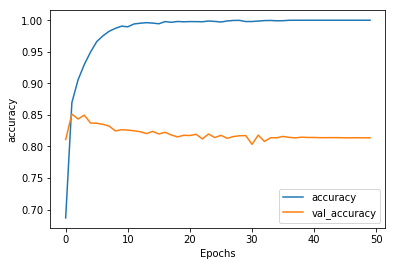

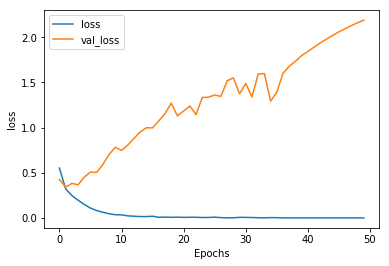

In [9]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [10]:
# Model Definition with LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/50
25000/25000 [==============================] - 99s 4ms/sample - loss: 0.5053 - accuracy: 0.7420 - val_loss: 0.3553 - val_accuracy: 0.8469
Epoch 2/50
25000/25000 [==============================] - 96s 4ms/sample - loss: 0.3125 - accuracy: 0.8754 - val_loss: 0.3538 - val_accuracy: 0.8511
Epoch 3/50
25000/25000 [==============================] - 98s 4ms/sample - loss: 0.2488 - accuracy: 0.9053 - val_loss: 0.3888 - val_accuracy: 0.8398
Epoch 4/50
25000/25000 [==============================] - 98s 4ms/sample - loss: 0.2091 - accuracy: 0.9245 - val_loss: 0.4443 - val_accuracy: 0.8341
Epoch 5/50
25000/25000 [==============================] - 98s 4ms/sample - loss: 0.1714 - accuracy: 0.9396 - val_loss: 0.4548 - val_accuracy: 0.8339
Epoch 6/50
25000/25000 [==============================] - 98s 4ms/sample - loss: 0.1477 - accuracy: 0.9484 - val_loss: 0.5843 - val_accuracy: 0.8247
Epoch 7/50
25000/25000 [==============================] 

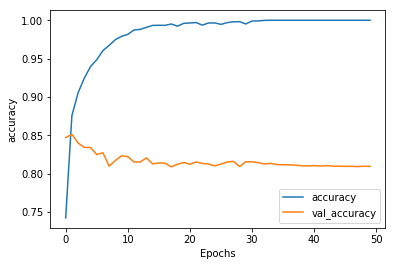

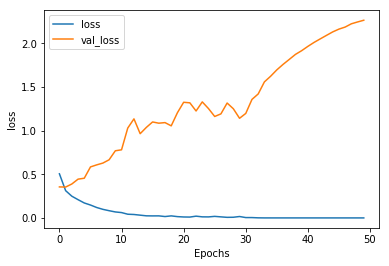

In [12]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [0]:
# Model Definition with Conv1D
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


In [0]:
num_epochs = 50
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

In [0]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')